<a href="https://colab.research.google.com/github/mayank-liv/Traffic-Image-Segmentation/blob/master/Traffic_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/lyft-udacity-challenge.zip'



Archive:  /content/drive/My Drive/lyft-udacity-challenge.zip
  inflating: dataA.tar.gz            
  inflating: dataE.tar.gz            
  inflating: dataC.tar.gz            error:  zipfile read error


In [0]:
!tar -xvf /content/dataA.tar.gz

dataA/
dataA/CameraRGB/
dataA/CameraRGB/02_00_171.png
dataA/CameraRGB/03_01_021.png
dataA/CameraRGB/02_00_190.png
dataA/CameraRGB/F2-60.png
dataA/CameraRGB/06_00_000.png
dataA/CameraRGB/08_00_220.png
dataA/CameraRGB/F68-90.png
dataA/CameraRGB/F63-21.png
dataA/CameraRGB/F1-30.png
dataA/CameraRGB/02_02_120.png
dataA/CameraRGB/09_00_170.png
dataA/CameraRGB/07_00_070.png
dataA/CameraRGB/09_00_201.png
dataA/CameraRGB/10_00_201.png
dataA/CameraRGB/F4-90.png
dataA/CameraRGB/08_00_091.png
dataA/CameraRGB/03_01_231.png
dataA/CameraRGB/08_00_120.png
dataA/CameraRGB/F69-21.png
dataA/CameraRGB/F9-20.png
dataA/CameraRGB/08_00_130.png
dataA/CameraRGB/F5-70.png
dataA/CameraRGB/02_02_161.png
dataA/CameraRGB/09_00_100.png
dataA/CameraRGB/F67-20.png
dataA/CameraRGB/F67-80.png
dataA/CameraRGB/05_00_201.png
dataA/CameraRGB/F6-1.png
dataA/CameraRGB/04_00_030.png
dataA/CameraRGB/F3-100.png
dataA/CameraRGB/10_00_190.png
dataA/CameraRGB/10_00_081.png
dataA/CameraRGB/F67-50.png
dataA/CameraRGB/02_00_011.png
da

In [0]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from tqdm import tqdm


In [0]:
image_path = '../content/dataA/CameraRGB/'
mask_path = '../content/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]



Text(0.5, 1.0, 'Segmentation')

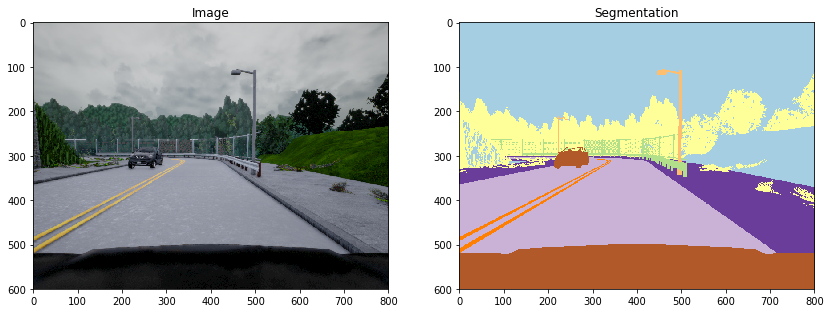

In [0]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

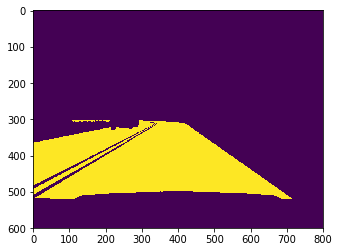

In [0]:
road = np.zeros((600, 800))
road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
plt.imshow(road)

In [0]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

100%|██████████| 1000/1000 [00:31<00:00, 32.01it/s]


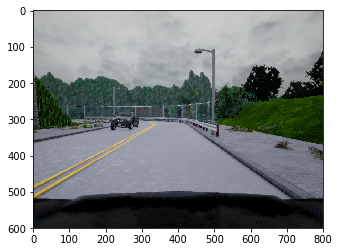

In [0]:
plt.imshow(images[1].reshape(600, 800, 3))

In [0]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [0]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [0]:
train_images.shape, val_images.shape, test_images.shape

((800, 600, 800, 3), (100, 600, 800, 3), (100, 600, 800, 3))

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 600, 800, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_2[0][0]            

In [0]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_masks, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(val_images, val_masks))


Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 49s 62ms/step - loss: 0.6509 - val_loss: 0.4226

Epoch 00001: val_loss improved from inf to 0.42260, saving model to model-sdc-seg-v2.h5
Epoch 2/100
800/800 [==============================] - 35s 44ms/step - loss: 0.4018 - val_loss: 0.3915

Epoch 00002: val_loss improved from 0.42260 to 0.39152, saving model to model-sdc-seg-v2.h5
Epoch 3/100
800/800 [==============================] - 37s 46ms/step - loss: 0.3696 - val_loss: 0.3754

Epoch 00003: val_loss improved from 0.39152 to 0.37537, saving model to model-sdc-seg-v2.h5
Epoch 4/100
800/800 [==============================] - 37s 46ms/step - loss: 0.3445 - val_loss: 0.3261

Epoch 00004: val_loss improved from 0.37537 to 0.32611, saving model to model-sdc-seg-v2.h5
Epoch 5/100
800/800 [==============================] - 36s 45ms/step - loss: 0.3097 - val_loss: 0.2762

Epoch 00005: val_loss improved from 0.32611 to 0.27621, saving model 

In [0]:
model.save('model_road_seg.h5')

Text(0.5, 1.0, 'Ground truth')

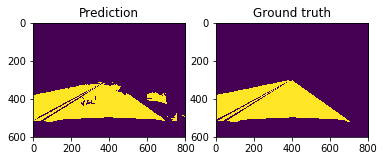

In [0]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')

Text(0.5, 1.0, 'Ground truth')

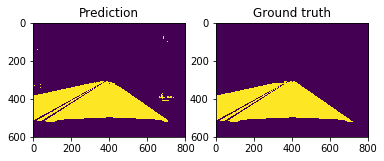

In [0]:
NUMBER += 1
my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600, 800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600, 800))
ax[1].set_title('Ground truth')